# Assignment CNNs - Part 2: Transfer Learning Strategies with Fast Food Classification


In this notebook, we will:
1. Import and prepare the Fast Food Classification dataset
2. Implement three different transfer learning strategies:
   - Feature extraction (frozen pre-trained model)
   - Fine-tuning last few layers
   - Full fine-tuning
3. Get experience on how sample size affects the strategy's performance
4. Get experience of the impact of choosing the right/wrong learning rate
5. Get experience with the different transfer learning strategies

## 0. Introduction

Transfer learning is a powerful technique that allows us to leverage pre-trained models for new tasks. However, different transfer learning strategies are suitable for different scenarios, particularly depending on:
- Sample size of the target dataset
- Similarity between source and target tasks
- Available computational resources

In this exercise, we'll explore different transfer learning strategies using the "Fast Food Classification Dataset - V2" from Kaggle.

## 1. Data Import and Cleaning

1. Download the ["Fast Food Classification Dataset - V2"](https://www.kaggle.com/datasets/utkarshsaxenadn/fast-food-classification-dataset/data) from Kaggle.

2. Unzip and ensure that the dataset in Colab is structured as follows:

```
|
|-- Fast Food Classification V2
|   |-- TFRecords
|   |-- Test
|   |-- Train
|   `-- Valid
|-- sample_data
`-- archive.zip
```

`Fast Food Classification V2` and `archive.zip` should be on the same level as the already existing `sample_data` directory from Colab. You can ignore the `TFRecords` subdirectory in the following tasks.

In [1]:
#!/bin/bash
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/utkarshsaxenadn/fast-food-classification-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  820M  100  820M    0     0  20.0M      0  0:00:40  0:00:40 --:--:-- 19.9M


In [2]:
!unzip -q archive.zip

3. Apply the provided `delete_invalid_images` function to check and remove any corrupted or invalid images in each of the three dataset directories.

In [3]:
import os
from PIL import Image

# Define the paths to the directories
directories = [
    "Fast Food Classification V2/Train",
    "Fast Food Classification V2/Valid",
    "Fast Food Classification V2/Test"
]

# Define supported image file extensions
supported_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

def delete_invalid_images(directory):
    """Goes through a directory and deletes any invalid or unsupported images."""
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Check if the file has a supported extension
            if not any(file.lower().endswith(ext) for ext in supported_extensions):
                print(f"Deleting unsupported file: {file_path}")
                os.remove(file_path)
                continue

            try:
                with Image.open(file_path) as img:
                    img.load()  # Ensure the image content can be read
                    if img.format not in ["JPEG", "PNG", "GIF", "BMP"]:
                        raise IOError("Unsupported image format")
            except (IOError, SyntaxError, AttributeError) as e:
                print(f"Deleting invalid or corrupted image: {file_path}")
                os.remove(file_path)

# Run the function for each directory
for dir_path in directories:
    delete_invalid_images(dir_path)

print("Invalid and unsupported image cleanup completed.")

Deleting invalid or corrupted image: Fast Food Classification V2/Train/Hot Dog/Hot Dog - Train (59).jpg
Invalid and unsupported image cleanup completed.


4. To reduce training time, only three classes are considered for the following training.

In [4]:
# prompt: In each of the Train, Test, and Valid folder in the folder "Fast Food Classification V2" that were just unzipped, only keep the folders Taquito, Crispy Chicken, and Donut. Remove the others.

import os
import shutil

# Define the root directory of the dataset
dataset_root = "Fast Food Classification V2"

# Define the subdirectories (Train, Test, Valid)
subdirectories = ["Train", "Test", "Valid"]

# Define the classes to keep
classes_to_keep = ["Pizza", "Hot Dog", "Burger"]

# Loop through each subdirectory
for subdir in subdirectories:
  subdir_path = os.path.join(dataset_root, subdir)

  # Loop through each folder (class) in the subdirectory
  for class_folder in os.listdir(subdir_path):
    class_folder_path = os.path.join(subdir_path, class_folder)

    # Check if it's a directory and if it's not one of the classes to keep
    if os.path.isdir(class_folder_path) and class_folder not in classes_to_keep:
      print(f"Removing folder: {class_folder_path}")
      shutil.rmtree(class_folder_path)

print("Folder cleanup completed.")

Removing folder: Fast Food Classification V2/Train/Donut
Removing folder: Fast Food Classification V2/Train/Sandwich
Removing folder: Fast Food Classification V2/Train/Fries
Removing folder: Fast Food Classification V2/Train/Baked Potato
Removing folder: Fast Food Classification V2/Train/Crispy Chicken
Removing folder: Fast Food Classification V2/Train/Taco
Removing folder: Fast Food Classification V2/Train/Taquito
Removing folder: Fast Food Classification V2/Test/Donut
Removing folder: Fast Food Classification V2/Test/Sandwich
Removing folder: Fast Food Classification V2/Test/Fries
Removing folder: Fast Food Classification V2/Test/Baked Potato
Removing folder: Fast Food Classification V2/Test/Crispy Chicken
Removing folder: Fast Food Classification V2/Test/Taco
Removing folder: Fast Food Classification V2/Test/Taquito
Removing folder: Fast Food Classification V2/Valid/Donut
Removing folder: Fast Food Classification V2/Valid/Sandwich
Removing folder: Fast Food Classification V2/Valid/F

### Creation of Different Training Dataset Sizes

   - Small: 50 images per class
   - Medium: 200 images per class  
   - Full: All available training images

To reduce training time, only three classes are considered in the training.

The validation and test sets will remain constant to ensure fair comparison.

In [5]:
import os
import numpy as np
import shutil
from pathlib import Path

# Constants
SMALL_SAMPLES = 50  # images per class
MEDIUM_SAMPLES = 200 # images per class

def create_sample_dataset(source_dir, target_dir, samples_per_class):
    """Creates a smaller dataset by randomly sampling from source directory"""
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    # Create target directory
    os.makedirs(target_dir)

    # For each class directory
    for class_dir in os.listdir(source_dir):
        source_class_path = os.path.join(source_dir, class_dir)
        target_class_path = os.path.join(target_dir, class_dir)

        if os.path.isdir(source_class_path):
            # Create class directory in target
            os.makedirs(target_class_path)

            # Get list of all images
            images = os.listdir(source_class_path)

            # Randomly sample specified number of images
            selected_images = np.random.choice(
                images,
                size=min(samples_per_class, len(images)),
                replace=False
            )

            # Copy selected images
            for img in selected_images:
                shutil.copy2(
                    os.path.join(source_class_path, img),
                    os.path.join(target_class_path, img)
                )

# Create sampled datasets
create_sample_dataset("./Fast Food Classification V2/Train", "./Train_Small", SMALL_SAMPLES)
create_sample_dataset("./Fast Food Classification V2/Train", "./Train_Medium", MEDIUM_SAMPLES)

## 2. Data Preprocessing

1. Load the training, validation and test datasets using the `image_dataset_from_directory` function. Specifically, set appropriate values for `label_mode`, `batch_size`, `image_size` and `shuffle`. Each dataset should get a fixed `seed` of `42`.

Checkout the documentation for details:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory



In [6]:
import tensorflow as tf

# Constants
LABEL_MODE = 'categorical' # TODO: Set appropriate value
SEED = 42 # TODO: Choose a value
IMAGE_HEIGHT = 150 # TODO: Set appropriate value
IMAGE_WIDTH = 150 # TODO: Set appropriate value
#Tip: Models that will be used with this data work usually best when the input images are of the same size as in the original training of the model.
BATCH_SIZE = 32

# Load the small dataset
train_data_small = tf.keras.preprocessing.image_dataset_from_directory(
    "Train_Small",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=100 #TODO: Set appropriate value
)

# Load the medium dataset
train_data_medium = tf.keras.preprocessing.image_dataset_from_directory(
    "Train_Medium",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=100 #TODO: Set appropriate value
)

# Load the full dataset
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast Food Classification V2/Train",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=100 #TODO: Set appropriate value
)

# Load validation dataset
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast Food Classification V2/Valid",
    label_mode='int',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=100 #TODO: Set appropriate value
)

# Load the test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast Food Classification V2/Test",
    label_mode='int',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=100 #TODO: Set appropriate value
)

# Optimize the datasets for training
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_data_small = (train_data_small
                    .cache()
                    .prefetch(PREFETCH_BUFFER_SIZE))

train_data_medium = (train_data_medium
                     .cache()
                     .prefetch(PREFETCH_BUFFER_SIZE))

train_data_full = (train_data_full
                   .cache()
                   .prefetch(PREFETCH_BUFFER_SIZE))

Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 4499 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


2. Add normalization and data augmentation as needed to the datasets.  
Which normalization is best? (Tip: Check how the original model was trained.)  
Which data augmentation makes sense?

In [7]:
# Training-specific preprocessing
train_preprocessing = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    # Rescale the image. Note the input shape is the desired size of the image: 150x150 with 3 bytes for color
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
    ])

def preprocess_dataset(image, label):
    image = train_preprocessing(image)  # Normalize
    image = data_augmentation(image)  # Augmentation for training only
    return image, label

train_data_small = train_data_small.map(preprocess_dataset)
train_data_medium = train_data_medium.map(preprocess_dataset)
train_data_full = train_data_full.map(preprocess_dataset)
validation_data = validation_data.map(lambda image, label: (train_preprocessing(image), label))

## 3. Model Definitions

Imports and Constants


In [8]:
import tensorflow as tf

CLASSES = 3 # TODO: Set the number of classes
IMAGE_HEIGHT = 150 # TODO: Choose an appropriate image height
IMAGE_WIDTH = 150 # TODO: Choose an appropriate image width

### Feature Extraction

1. Create a feature extraction model using the Inception V3 architecture.
2. Freeze all layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.


In [9]:
def create_feature_extraction_model():
    """Creates model with frozen base layers (feature extraction)

    Discussion points:
    1. Why might a simpler classification head be sufficient for transfer learning?
    2. When would you consider adding more layers to the classification head?
    3. How does the number of trainable parameters affect training with small datasets?
    """
    # Load pre-trained InceptionV3 with correct input size
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Freeze all layers for feature extraction
    base_model.trainable = False

    # Simple classification head
    # - GlobalAveragePooling2D reduces spatial dimensions
    # - Final Dense layer maps to class probabilities
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model

### Fine-Tuning Last Few Layers

1. Create a fine-tuning model using the Inception V3 architecture.
2. Unfreeze the last few layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.


In [10]:
def create_fine_tuning_model():
    """Creates model with last few layers unfrozen for fine-tuning"""

    # Load pre-trained InceptionV3 with correct input size
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Freeze all layers except last few blocks
    base_model.trainable = True
    for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model


### Full Fine-Tuning

1. Create a fine-tuning model using the Inception V3 architecture.
2. Unfreeze all layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.

In [11]:
def create_full_fine_tuning_model():
    """Creates model with all layers unfrozen for full fine-tuning"""

    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Make all layers trainable
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model


## 4. Model Training

## Tasks

1. Optimize two different models either using the same transfer learning strategy and two of the three datasets with different sizes or alternatively use one of the datasets with two different learning strategies.

2. Find out what the arguments of the early stopping callback function mean.

3. Choose appropriate learning rates.
Tips for choosing it:
- Start with the Default: Begin with the Adam optimizer's default learning rate of 0.001. This is often a good starting point.
- When fine-tuning (especially full fine-tuning), consider using a smaller learning rate than the default. This helps prevent large updates to the pre-trained weights, which could disrupt the learned features. A learning rate of 1e-4 or 1e-5 is a good starting point.
- The best learning rate will depend on the specific dataset and model. Experiment with different values and observe the training and validation performance. Look for a learning rate that allows the model to converge smoothly without overshooting or getting stuck in a local minimum.



### Example for Training of the Feature Extraction Model with the Small Dataset

In [12]:
LEARNING_RATE = 0.0001 # Choose appropriately

# Settings for the Feature Extraction Model on the small dataset
model_feature_extraction_small = create_feature_extraction_model()
model_feature_extraction_small.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Model Summary
model_feature_extraction_small.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [13]:
def to_integer_labels(images, labels):
    return images, tf.argmax(labels, axis=1)

train_data_small = train_data_small.map(to_integer_labels)

In [21]:
history_feature_extraction_small = model_feature_extraction_small.fit(
    train_data_small,
    validation_data=validation_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.7534 - loss: 0.6499 - val_accuracy: 0.8111 - val_loss: 0.4777
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 473ms/step - accuracy: 0.7399 - loss: 0.5506 - val_accuracy: 0.8111 - val_loss: 0.4815
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 913ms/step - accuracy: 0.7580 - loss: 0.6256 - val_accuracy: 0.8078 - val_loss: 0.4941
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.8286 - loss: 0.5169 - val_accuracy: 0.8033 - val_loss: 0.5041
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.6652 - loss: 0.6406 - val_accuracy: 0.8022 - val_loss: 0.4885
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 532ms/step - accuracy: 0.7655 - loss: 0.5685 - val_accuracy: 0.8111 - val_loss: 0.4785
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 926ms/step - accuracy: 0.7812 - loss: 0.5149 - val_accuracy: 0.8122 - val_loss: 0.4798
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.7654 - loss: 0.5986 - val_accuracy: 0.8056 - v

In [24]:
LEARNING_RATE = 0.0001 # Choose appropriately

# Settings for the Feature Extraction Model on the small dataset
model_feature_extraction_medium = create_feature_extraction_model()
model_feature_extraction_medium.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Model Summary
model_feature_extraction_medium.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:
train_data_medium = train_data_medium.map(to_integer_labels)

In [22]:
history_feature_extraction_medium = model_feature_extraction_medium.fit(
    train_data_medium,
    validation_data=validation_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.7678 - loss: 0.6468 - val_accuracy: 0.8167 - val_loss: 0.4795
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.7220 - loss: 0.6755 - val_accuracy: 0.8167 - val_loss: 0.4703
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.7843 - loss: 0.5782 - val_accuracy: 0.8200 - val_loss: 0.4682
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.7800 - loss: 0.5538 - val_accuracy: 0.8222 - val_loss: 0.4644
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.7729 - loss: 0.6039 - val_accuracy: 0.8200 - val_loss: 0.4640
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.7585 - loss: 0.6234 - val_accuracy: 0.8156 - val_loss: 0.4729
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.7710 - loss: 0.5679 - val_accuracy: 0.8222 - val_loss: 0.4611
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - accuracy: 0.7705 - loss: 0.5643 - val_ac

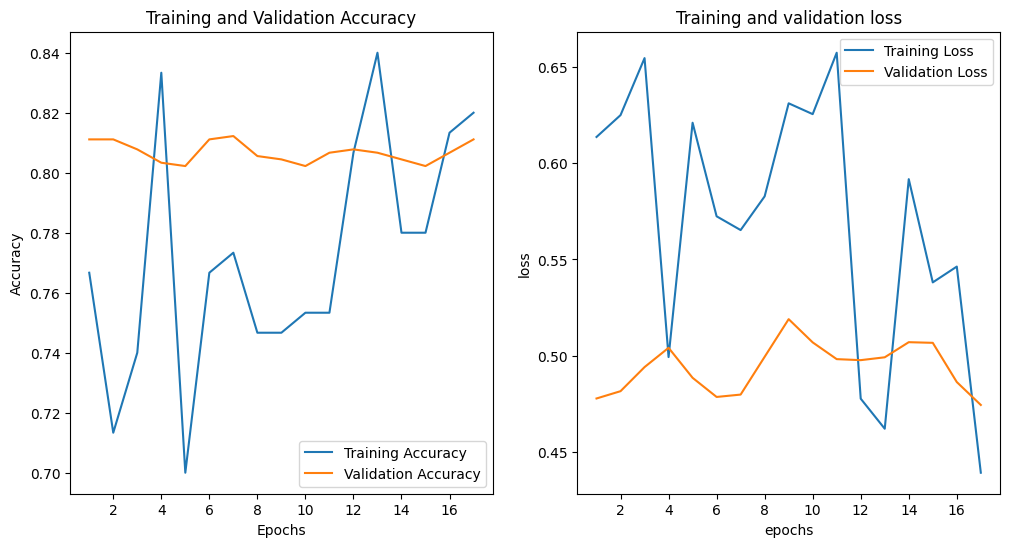

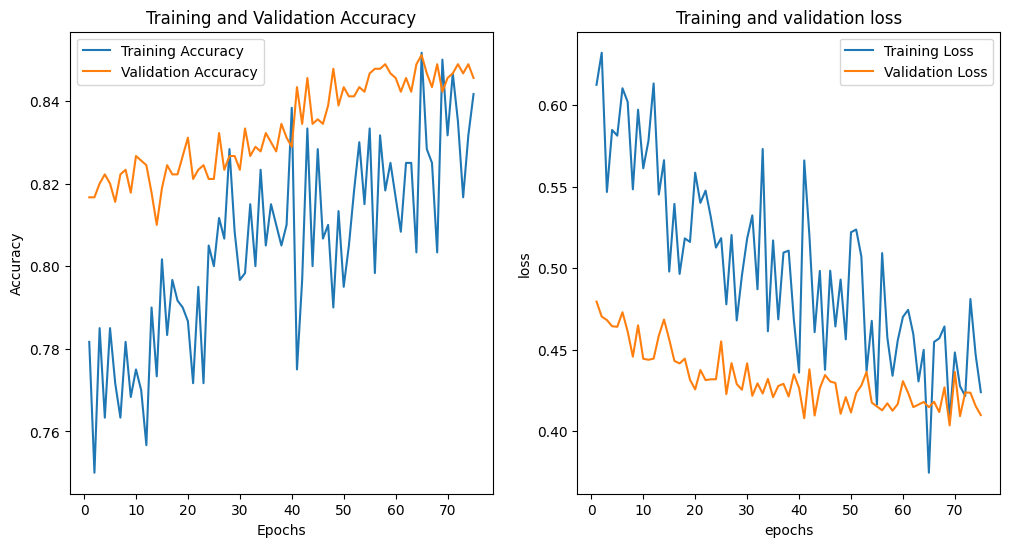

In [23]:
import matplotlib.pyplot as plt

# Plot the model training history
def plot_training_history(history):
    # Extracting accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Setting up the number of epochs for the x-axis
    epochs_range = range(1, len(acc) + 1)

    # Plotting training and validation accuracy
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs_range, acc, label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()
    ax[1].plot(epochs_range, loss, label='Training Loss')
    ax[1].plot(epochs_range, val_loss, label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_training_history(history_feature_extraction_small)
plot_training_history(history_feature_extraction_medium)

In [25]:
LEARNING_RATE = 0.00001 # Choose appropriately

# Settings for the Feature Extraction Model on the small dataset
model_fine_tuning_medium = create_fine_tuning_model()
model_fine_tuning_medium.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Model Summary
model_fine_tuning_medium.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 1,941,507 (7.41 MB)

 Non-trainable params: 19,867,424 (75.79 MB)

In [26]:
history_fine_tuning_medium = model_fine_tuning_medium.fit(
    train_data_medium,
    validation_data=validation_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3261 - loss: 1.4326 - val_accuracy: 0.4478 - val_loss: 1.3534
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.4090 - loss: 1.1980 - val_accuracy: 0.4956 - val_loss: 1.1156
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.4727 - loss: 1.0412 - val_accuracy: 0.5400 - val_loss: 0.9760
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step - accuracy: 0.5127 - loss: 0.9577 - val_accuracy: 0.5889 - val_loss: 0.8809
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.5453 - loss: 0.9099 - val_accuracy: 0.6444 - val_loss: 0.7908
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - accuracy: 0.6695 - loss: 0.8323 - val_accuracy: 0.6844 - val_loss: 0.7088
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.6434 - loss: 0.8126 - val_accuracy: 0.7067 - val_loss: 0.6647
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.6324 - loss: 0.7412 - val_

In [27]:
LEARNING_RATE = 0.00001 # Choose appropriately

# Settings for the Feature Extraction Model on the small dataset
model_full_fine_tuning_medium = create_full_fine_tuning_model()
model_full_fine_tuning_medium.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Model Summary
model_full_fine_tuning_medium.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,904,035 (91.19 MB)

 Trainable params: 23,869,603 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [28]:
history_full_fine_tuning_medium = model_full_fine_tuning_medium.fit(
    train_data_medium,
    validation_data=validation_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.4044 - loss: 1.2409 - val_accuracy: 0.3600 - val_loss: 1.3245
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 372ms/step - accuracy: 0.5415 - loss: 1.0195 - val_accuracy: 0.5133 - val_loss: 1.0293
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.5505 - loss: 0.9602 - val_accuracy: 0.6322 - val_loss: 0.8209
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.6144 - loss: 0.8866 - val_accuracy: 0.6933 - val_loss: 0.7227
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.6898 - loss: 0.8047 - val_accuracy: 0.7211 - val_loss: 0.6721
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.7140 - loss: 0.7699 - val_accuracy: 0.7522 - val_loss: 0.6134
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.7300 - loss: 0.7249 - val_accuracy: 0.7667 - val_loss: 0.5825
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.7295 - loss: 0.6864 - val_a

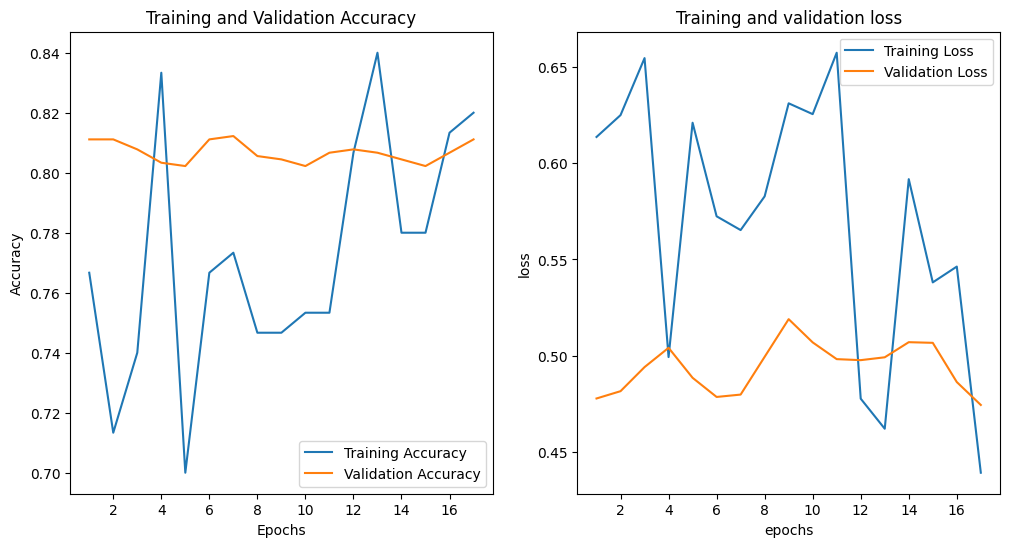

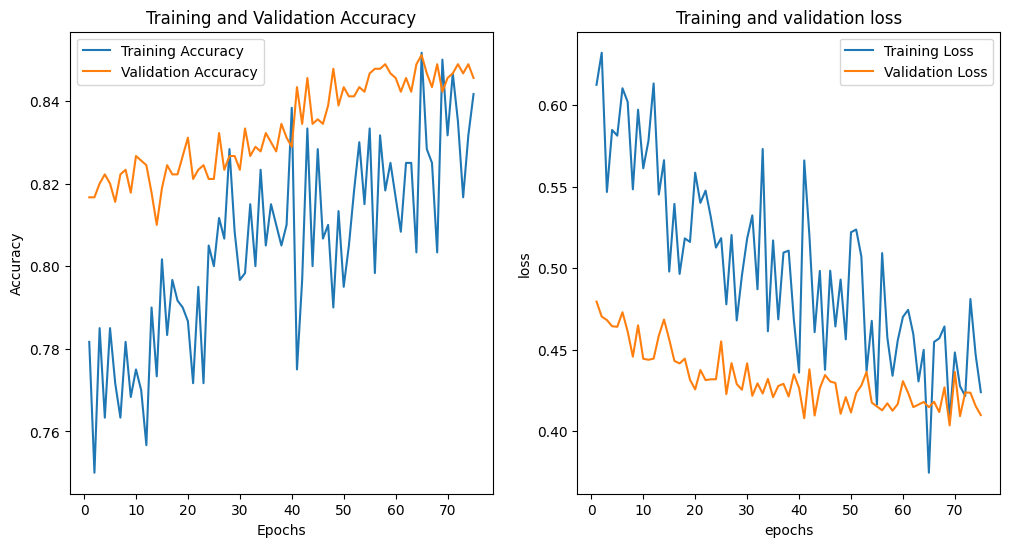

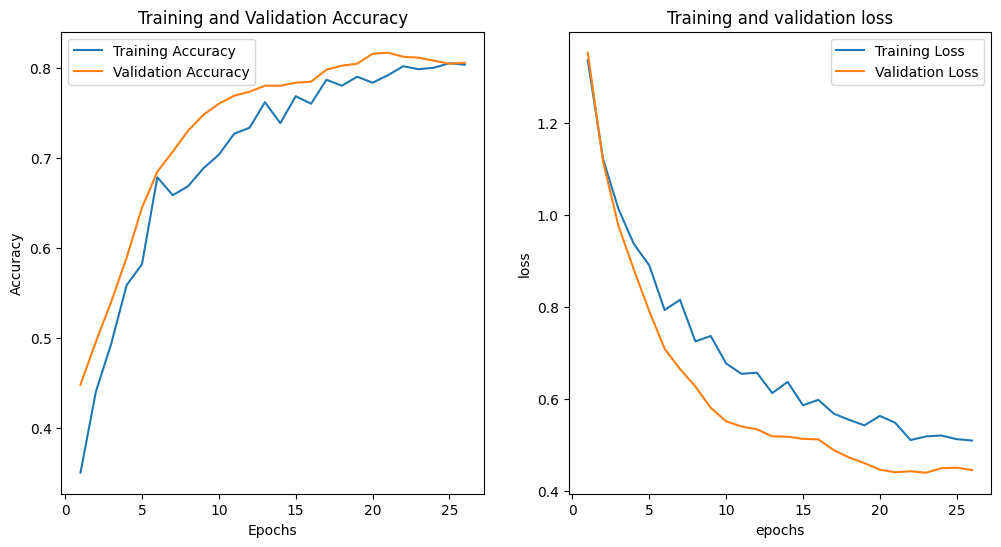

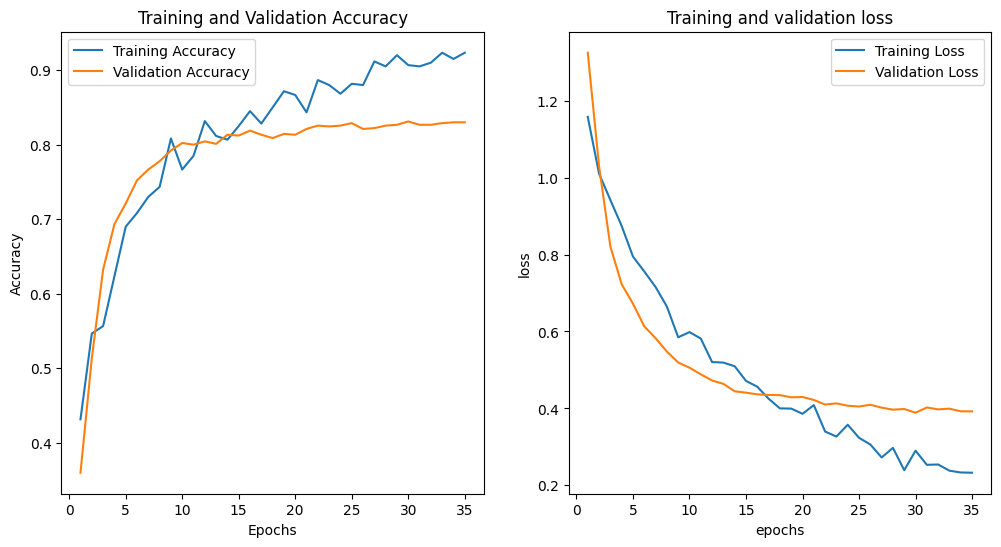

In [29]:
plot_training_history(history_feature_extraction_small)
plot_training_history(history_feature_extraction_medium)
plot_training_history(history_fine_tuning_medium)
plot_training_history(history_full_fine_tuning_medium)